In [1]:
import numpy as np
import pandas as pd
import sklearn as skl
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from matplotlib.ticker import FuncFormatter

import datetime
import time
import os
import pytz
import json
import csv

from pprint import pprint


In [2]:
# GLOBAL SETTINGS

# Data directories
#coin_dataDir = 'DATA/TESTDIR/' # Debug dir for testing I/O logic and/or issues. It should be a clone of the above dir.
coin_dataDir = 'DATA/COMBINEDDATA/'
plot_dataDir = 'DATA/INITIAL_INSIGHTS/PCA_FACTORS'
riskFactor_dataDir = 'DATA/RISKFACTORSDATA/'


# Date ranges
START = 2020
END = 2022

# Helpers
isdir = os.path.isdir(riskFactor_dataDir)
idx = pd.IndexSlice
sns.set_style('whitegrid')
np.random.seed(42)

# END GLOBAL SETTINGS

In [3]:
# FINDING RISK FACTORS WITH PCA

# Read in MDF with initial coin pool
cpool_mdf = pd.read_csv(coin_dataDir + 'CoinPool.csv')
cpool_mdf.rename(columns={'Unnamed: 0': 'Dates'}, inplace=True)
cpool_mdf['Dates'] = pd.to_datetime(cpool_mdf['Dates'])
cpool_mdf.set_index(['Dates', 'Coin'], inplace=True)
print(cpool_mdf.columns)


# Isolate the close prices and calculate daily returns
returns_df = cpool_mdf.loc[idx[str(START):str(END), :], 'Close'].unstack('Coin').pct_change()

# Winsorize at 2.5% and 97.5% quantiles
returns_df = returns_df.clip(lower=returns_df.quantile(q=.025),
                       upper=returns_df.quantile(q=.975),
                       axis=1)

# Drop coins and adates that do not have complete data for 95%  of the time period
returns_df = returns_df.dropna(thresh=int(returns_df.shape[0] * .95), axis=1)
returns_df = returns_df.dropna(thresh=int(returns_df.shape[1] * .95))

# Saved the returns as they are for comparison to Eigenportfolios at the end of the script
base_returns = returns_df
#print("After Dropping coins for missing data")
#print(returns_df.info())

# impute any remaining missing values using daily average returns
daily_avg = returns_df.mean(1)
returns_df = returns_df.apply(lambda x: x.fillna(daily_avg))
print(returns_df.info())

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 777 entries, 2020-01-02 to 2022-02-16
Data columns (total 56 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   algorand               777 non-null    float64
 1   arweave                777 non-null    float64
 2   basic-attention-token  777 non-null    float64
 3   binancecoin            777 non-null    float64
 4   bitcoin                777 non-null    float64
 5   bitcoin-cash           777 non-null    float64
 6   bitcoin-cash-sv        777 non-null    float64
 7   bittorrent-old         777 non-null    float64
 8   blockstack             777 non-null    float64
 9   cardano                777 non-null    float64
 10  celsius-degree-token   777 non-null    float64
 11  chainlink              777 non-null    float64
 12  chiliz                 777 non-null    float64
 13  cosmos     

In [4]:
# Verify no NaNs left in the data
for c in returns_df:
    print(c + " " + str(returns_df[c].isnull().sum()))

algorand 0
arweave 0
basic-attention-token 0
binancecoin 0
bitcoin 0
bitcoin-cash 0
bitcoin-cash-sv 0
bittorrent-old 0
blockstack 0
cardano 0
celsius-degree-token 0
chainlink 0
chiliz 0
cosmos 0
crypto-com-chain 0
dash 0
decentraland 0
dogecoin 0
ecomi 0
enjincoin 0
eos 0
ethereum 0
ethereum-classic 0
fantom 0
ftx-token 0
gatechain-token 0
harmony 0
havven 0
hedera-hashgraph 0
huobi-token 0
iota 0
kadena 0
klay-token 0
kucoin-shares 0
kusama 0
leo-token 0
litecoin 0
loopring 0
maker 0
matic-network 0
monero 0
nem 0
neo 0
nexo 0
okb 0
quant-network 0
ripple 0
stellar 0
terra-luna 0
tezos 0
theta-fuel 0
theta-token 0
thorchain 0
tron 0
vechain 0
zcash 0


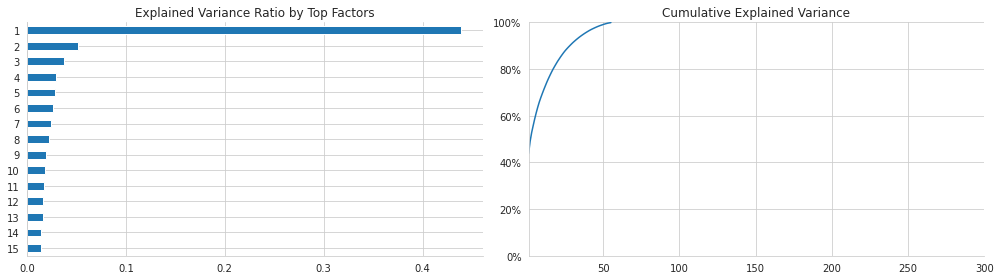

In [5]:
# Use the defaults for PCA to computer principle components of the returns
pca = PCA(n_components='mle')
fitted_returns = pca.fit(returns_df)
#print(fitted_returns)

# Plot the Explained Variance and Top Factors
# The top Factors found by PCA can be used as the "Risk Factors" for our model instead of the FAMA-French Risk Factors
fig, axes = plt.subplots(ncols=2, figsize=(14, 4))
title = 'Explained Variance Ratio by Top Factors'
var_expl = pd.Series(fitted_returns.explained_variance_ratio_)
var_expl.index += 1
var_expl.iloc[:15].sort_values().plot.barh(title=title,
                                           ax=axes[0])
var_expl.cumsum().plot(ylim=(0, 1),
                       ax=axes[1],
                       title='Cumulative Explained Variance',
                       xlim=(1, 300))
axes[1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))
sns.despine()
fig.tight_layout()

In [6]:
'''
It appears the most important factor explains well over 40% of the daily return variation.
Furthermore, it looks like about 10 factors explain 80% of the returns in our cross section of 40 crypto coins.
About 5 coins explain 60% of the returns. 
Though the initial pool of coins was larger than 40 we dropped several due to lack of data.
'''

# Isolate the first X factors
risk_factors = pd.DataFrame(pca.transform(returns_df)[:, :4],
                            columns=['Principal Component 1', 'Principal Component 2','Principal Component 3',
                                     'Principal Component 4'],
                            index=returns_df.index)

#print("PCA RISK FACTOR DATA")
#print(risk_factors.info())

# Save the Risk Factor data data
if isdir == False:
    os.makedirs(riskFactor_dataDir)
    print("Directory '% s' created" % riskFactor_dataDir)
    risk_factors.to_hdf(f'{riskFactor_dataDir}PCA_Risk_Factors.h5', 'PCA_Risk_Factors')
    risk_factors.to_csv(f'{riskFactor_dataDir}PCA_Risk_Factors.csv')
    print(f"The PCA Factors data has been saved to {riskFactor_dataDir} as a MultiIndex dataframe")

else:
    risk_factors.to_hdf(f'{riskFactor_dataDir}PCA_Risk_Factors.h5', 'PCA_Risk_Factors')
    risk_factors.to_csv(f'{riskFactor_dataDir}PCA_Risk_Factors.csv')
    print(f"The PCA Factors data has been saved to {riskFactor_dataDir} as a MultiIndex dataframe")



# Verify factor correlation or non-correlation
factor_corr_1_1 = risk_factors['Principal Component 1'].corr(risk_factors['Principal Component 1'])
factor_corr_1_2 = risk_factors['Principal Component 1'].corr(risk_factors['Principal Component 2'])
factor_corr_1_3 = risk_factors['Principal Component 1'].corr(risk_factors['Principal Component 3'])
factor_corr_1_4 = risk_factors['Principal Component 1'].corr(risk_factors['Principal Component 4'])
factor_corr_2_3 = risk_factors['Principal Component 2'].corr(risk_factors['Principal Component 3'])
factor_corr_2_4 = risk_factors['Principal Component 2'].corr(risk_factors['Principal Component 4'])

print("Factor Correlations")
print("Factors 1 & 1 " + str(factor_corr_1_1))
print("Factors 1 & 2 " + str(factor_corr_1_2))
print("Factors 1 & 3 " + str(factor_corr_1_3))
print("Factors 2 & 3 " + str(factor_corr_2_3))
print("Factors 1 & 4 " + str(factor_corr_1_4))
print("Factors 2 & 4 " + str(factor_corr_2_4))


The PCA Factors data has been saved to DATA/RISKFACTORSDATA/ as a MultiIndex dataframe
Factor Correlations
Factors 1 & 1 1.0
Factors 1 & 2 2.4542702219877592e-14
Factors 1 & 3 -1.158862256017843e-15
Factors 2 & 3 -3.876974723638948e-17
Factors 1 & 4 -1.0496904538717513e-16
Factors 2 & 4 9.336551924848226e-17


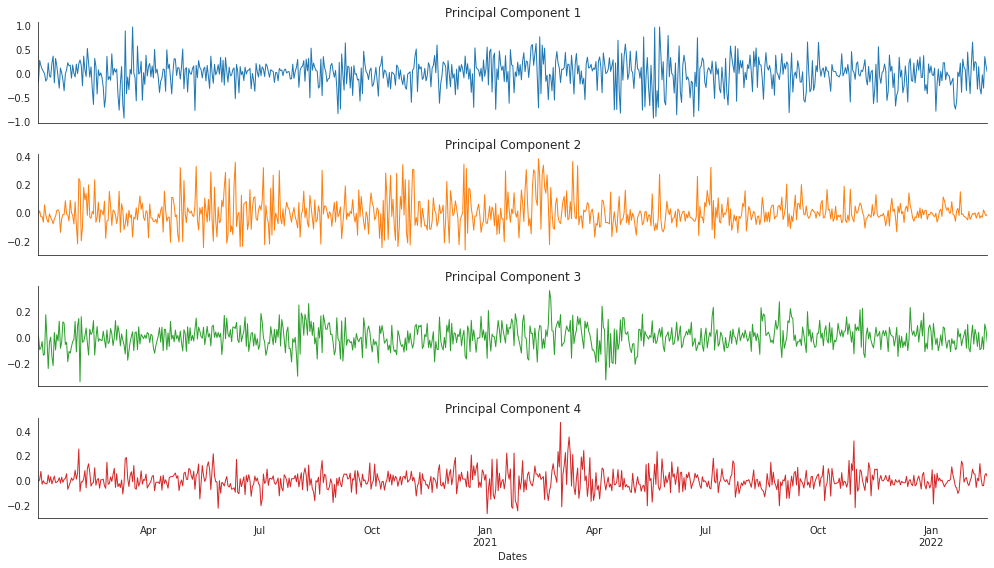

In [7]:
'''
In this case factors 1 and 2 are pretty correlated. But factors 1 and 3 are far less correlated, factors 2 and 3 are
less correlated than factors 1 and 2.
'''

#  Plot with Seaborn
with sns.axes_style('white'):
    risk_factors.plot(subplots=True,
                      figsize=(14, 8),
                      title=risk_factors.columns.tolist(),
                      legend=False,
                      rot=0,
                      lw=1,
                      xlim=(risk_factors.index.min(),
                            risk_factors.index.max()))

    sns.despine()
    plt.tight_layout()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Trial                250 non-null    int64  
 1   Principal Component  250 non-null    int64  
 2   Value                250 non-null    float64
 3   Cumulative           250 non-null    float64
dtypes: float64(2), int64(2)
memory usage: 7.9 KB
None


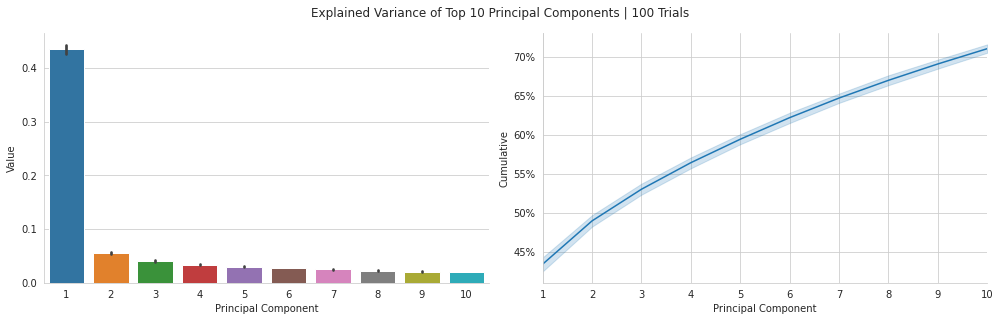

In [8]:
# Same as above but with 100 trials

# Isolate the close prices and calculate daily returns
returns_df = cpool_mdf.loc[idx[str(START):str(END), :], 'Close'].unstack('Coin').pct_change()
#print("Regenerate daily Returns")
#print(returns_df.info())

# Winsorize at 2.5% and 97.5% quantiles
returns_df = returns_df.clip(lower=returns_df.quantile(q=.025),
                       upper=returns_df.quantile(q=.975),
                       axis=1)
#print("Winsorize again daily Returns")
#print(returns_df.info())

# Fit PCA and do the trials
pca = PCA()
n_trials, n_samples = 25, 250
explained = np.empty(shape=(n_trials, n_samples))

# The trials
for trial in range(n_trials):
    returns_sample = returns_df.sample(n=n_samples)
    returns_sample = returns_sample.dropna(thresh=int(returns_sample.shape[0] * .95), axis=1)
    returns_sample = returns_sample.dropna(thresh=int(returns_sample.shape[1] * .95))
    daily_avg = returns_sample.mean(1)
    returns_sample = returns_sample.apply(lambda x: x.fillna(daily_avg))
    #print("After Dropping coins for missing data")
    #print(returns_sample.info())
    fitted_returns = pca.fit(returns_sample)
    explained[trial, :len(pca.components_)] = fitted_returns.explained_variance_ratio_

#pprint(explained)

explained = pd.DataFrame(explained, columns=list(range(1, explained.shape[1] + 1)))
#print("All the explained covariance PCA components")
#print(explained.info())

# Plot with Seaborn
fig, axes = plt.subplots(ncols=2, figsize=(14, 4.5))
pc10 = explained.iloc[:, :10].stack().reset_index()
pc10.columns = ['Trial', 'Principal Component', 'Value']

pc10['Cumulative'] = pc10.groupby('Trial').Value.transform(np.cumsum)
print(pc10.info())
sns.barplot(x='Principal Component', y='Value', data=pc10, ax=axes[0])
sns.lineplot(x='Principal Component', y='Cumulative', data=pc10, ax=axes[1])
axes[1].set_xlim(1, 10)
axes[1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))
fig.suptitle('Explained Variance of Top 10 Principal Components | 100 Trials')
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.90)


In [9]:
# EIGENPORTFOLIO

# Searching for a weights to weigh the coins in a future portfolio.
# Visualizing the PCA factors in this way can also help decide which of the componenets to use
# As features in the dataset representing risk factors
# Read in MDF with initial coin pool
cpool_mdf = pd.read_csv(coin_dataDir + 'CoinPool.csv')
cpool_mdf.rename(columns={'Unnamed: 0': 'Dates'}, inplace=True)
cpool_mdf['Dates'] = pd.to_datetime(cpool_mdf['Dates'])
cpool_mdf.set_index(['Dates', 'Coin'], inplace=True)

top15 = cpool_mdf.loc['2022-01-07' , 'Market Cap'].nlargest(15)
top15 = top15.reset_index( level =1 )
top15.index = top15['Coin']
top15.drop('Coin',axis=1,inplace=True)
print(top15)

                    Market Cap
Coin                          
bitcoin           7.930510e+11
ethereum          3.821842e+11
binancecoin       7.574553e+10
solana            4.330671e+10
cardano           3.921656e+10
ripple            3.631377e+10
polkadot          2.714258e+10
terra-luna        2.543363e+10
avalanche-2       2.162580e+10
dogecoin          2.057626e+10
shiba-inu         1.613740e+10
matic-network     1.454294e+10
crypto-com-chain  1.200827e+10
chainlink         1.188291e+10
cosmos            1.183044e+10


In [10]:
# Calculate the returns for  the top 15 coins based on Market Capitalization
returns_df = cpool_mdf.loc[idx[str(START):str(END), top15.index], 'Close'].unstack('Coin').pct_change()
#print(returns_df.info())

# Winsorize at 2.5% and 97.5% quantiles
returns_df = returns_df.clip(lower=returns_df.quantile(q=.025),
                       upper=returns_df.quantile(q=.975),
                       axis=1)

# Base pool of top 15 by Mcap, for measures the Eigenportfolio performance at the end of the script
base_returns2 = returns_df

# Normalize/Scale
normed_returns_df = pd.DataFrame(scale(returns_df
                       .clip(lower=returns_df.quantile(q=.025),
                             upper=returns_df.quantile(q=.975),
                             axis=1)
                      .apply(lambda x: x.sub(x.mean()).div(x.std()))), columns = returns_df.columns,index=returns_df.index)

print(normed_returns_df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 778 entries, 2020-01-01 to 2022-02-16
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   binancecoin       777 non-null    float64
 1   bitcoin           777 non-null    float64
 2   cardano           777 non-null    float64
 3   chainlink         777 non-null    float64
 4   cosmos            777 non-null    float64
 5   crypto-com-chain  777 non-null    float64
 6   dogecoin          777 non-null    float64
 7   ethereum          777 non-null    float64
 8   matic-network     777 non-null    float64
 9   ripple            777 non-null    float64
 10  terra-luna        777 non-null    float64
 11  solana            677 non-null    float64
 12  shiba-inu         564 non-null    float64
 13  polkadot          547 non-null    float64
 14  avalanche-2       512 non-null    float64
dtypes: float64(15)
memory usage: 97.2 KB
None


AFTER DROPPING COINS THAT HAVE DATA FOR LESS THAN 95% OF THE TOTAL PERIODS WE WANT
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 777 entries, 2020-01-02 to 2022-02-16
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   binancecoin       777 non-null    float64
 1   bitcoin           777 non-null    float64
 2   cardano           777 non-null    float64
 3   chainlink         777 non-null    float64
 4   cosmos            777 non-null    float64
 5   crypto-com-chain  777 non-null    float64
 6   dogecoin          777 non-null    float64
 7   ethereum          777 non-null    float64
 8   matic-network     777 non-null    float64
 9   ripple            777 non-null    float64
 10  terra-luna        777 non-null    float64
dtypes: float64(11)
memory usage: 72.8 KB
None
EXPLAINED GROWTH BY FACTORS ACCORDING TO PCA
Explained Variance    0.824763
dtype: float64
   Explained Variance
0            0.384418


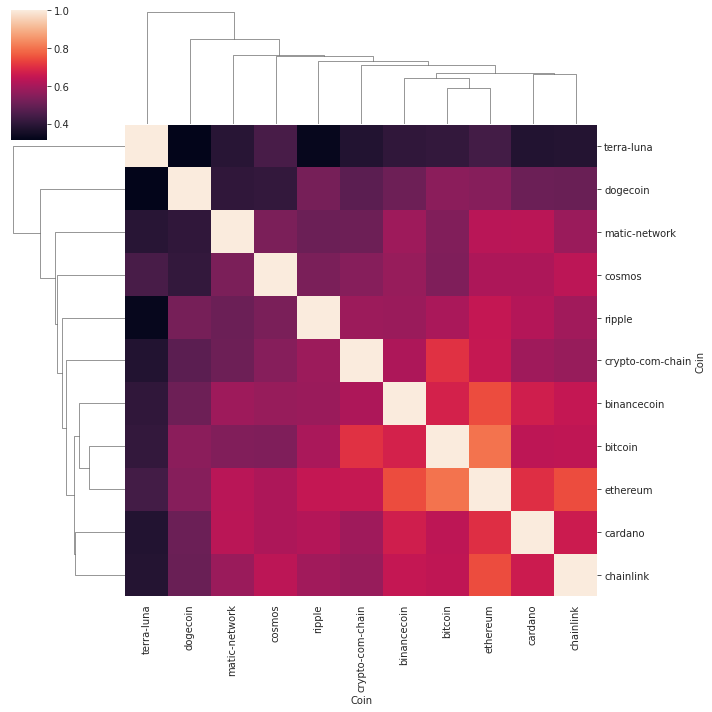

In [11]:
# Drop coins and dates that do not have complete data for 95%  of the time period
normed_returns_df = normed_returns_df.dropna(thresh=int(normed_returns_df.shape[0] * .95), axis=1)
normed_returns_df = normed_returns_df.dropna(thresh=int(normed_returns_df.shape[1] * .95))

# To compare against wieghted Eigenportfolios at the end of the script
scaled_base_returns = normed_returns_df
print("After dropping coins that have data for less than 95% of the total periods we want".upper())
print(normed_returns_df.info())

# Apply np.cov() to the normalized returns to see the strength of correlation among the coin returns
cov = normed_returns_df.cov()
covariance_map = sns.clustermap(cov)
#covariance_map.savefig(plot_dataDir + 'Top_15_Covariance_Cluster_map.png')

# Feed the correlated returns to PCA and check which factors explain the most growth
pca = PCA()
pca = pca.fit(cov)
exp_var15 = pd.Series(pca.explained_variance_ratio_).to_frame('Explained Variance')
print("Explained growth by factors according to PCA".upper())
print(exp_var15.head().sum())
print(exp_var15.head())

# Normalize the four largest components PCA components so that they sum to 1
# Prepare to use them as weights for portfolios to compare to an equal-weighted portfolio formed from all coins
# In this case all the coins in the coin pool
top4 = pd.DataFrame(pca.components_[:4], columns=cov.columns)
eigen_portfolios = top4.div(top4.sum(1), axis=0)
eigen_portfolios.index = [f'Portfolio {i}' for i in range(1, 5)]
print(eigen_portfolios.info())

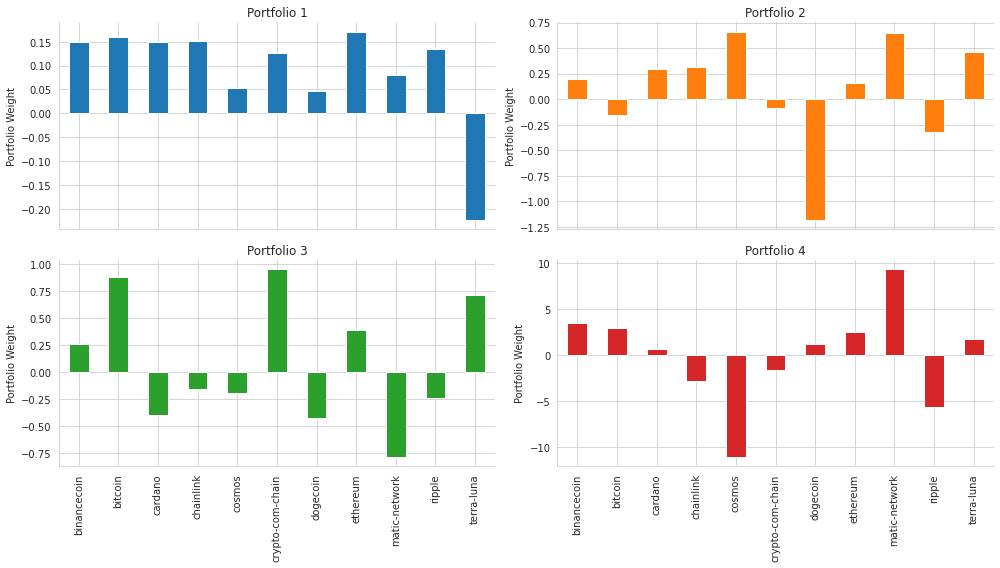

In [12]:
# Visualize the Eigenportfolio weights
axes = eigen_portfolios.T.plot.bar(subplots=True,
                                   layout=(2, 2),
                                   figsize=(14, 8),
                                   legend=False)
for ax in axes.flatten():
    ax.set_ylabel('Portfolio Weight')
    ax.set_xlabel('')
sns.despine()
plt.tight_layout()

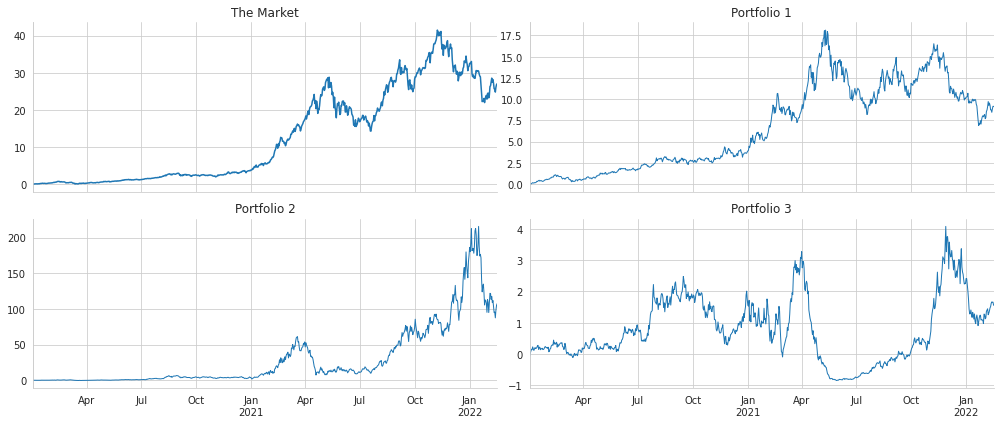

In [13]:
# Visualize the performance of the Eigenportfolios
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 6), sharex=True)
axes = axes.flatten()
base_returns.mean(1).add(1).cumprod().sub(1).plot(title='The Market', ax=axes[0])
for i in range(3):
    rc = base_returns.mul(eigen_portfolios.iloc[i]).sum(1).add(1).cumprod().sub(1)
    rc.plot(title=f'Portfolio {i+1}', ax=axes[i+1], lw=1, rot=0)

for i in range(4):
    axes[i].set_xlabel('')
sns.despine()
fig.tight_layout()